# Finite Impulse Response Filter Implementation

### Author: Cagil Gumus


$$ y_n = \sum_{k=0}^{M-1} h_k x_{n-k} $$


where $ x_{n} $ is the ADC output (16 bits signed) and $ h_k $ is the coefficients. The word taps is used for $ M $. For example: 2-taps FIR filter would have the form: 

$$ y_n = x_{n}/2 + x_{n-1}/2 $$

[Referenced from here](https://www.cbcity.de/die-fft-mit-python-einfach-erklaert)



In [27]:
from __future__ import division
from scipy import signal, fft, ifft
from scipy.signal import kaiserord, lfilter, firwin, freqz
import numpy as np
import matplotlib.pyplot as plt


In [28]:
freq = 10 # in Hz 
sampling_freq = 1000 # in Hz
periods = 1 # Number of periods to be printed
amplitude = 100

np.random.seed(1234) # needed for adding jitter

x = np.arange(0,periods/freq, 1/sampling_freq)

total_samples = len(x)
print("Total sample points: " + str(total_samples))

Total sample points: 100


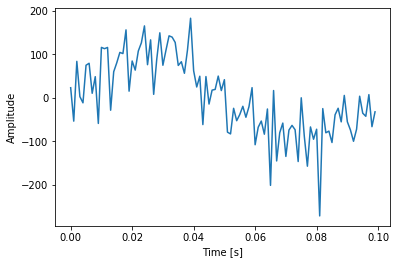

In [29]:
y = amplitude * (np.sin(2*np.pi*freq*x) + 0.5*np.random.randn(x.size))
plt.ylabel("Amplitude")
plt.xlabel("Time [s]")
plt.plot(x,y)

Now we are going to take the fft of the signal 

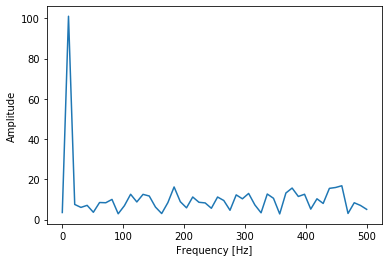

In [30]:
fft_signal = fft(y)

N = total_samples/2

xfreq = np.linspace(0,sampling_freq/2, N)


plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(xfreq, (2/total_samples)*abs(fft_signal[:int(N)])) # 2/N normalization

Now lets eliminate the 'Leakage effect' by introducing the windows

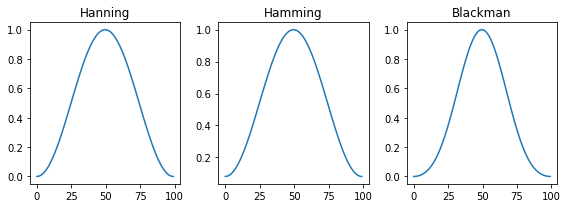

In [31]:
hann = np.hanning(len(y))
hamm = np.hamming(len(y))
black= np.blackman(len(y))

plt.figure(figsize=(8,3))
plt.subplot(131)
plt.plot(hann)
plt.title('Hanning')
plt.subplot(132)
plt.plot(hamm)
plt.title('Hamming')
plt.subplot(133)
plt.plot(black)
plt.title('Blackman')
plt.tight_layout()

Now lets amplitude modulate our input signal with Hanning Window

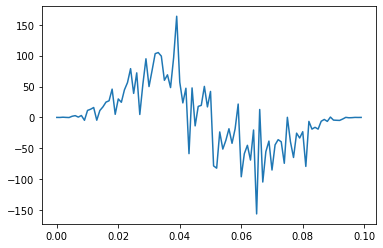

In [32]:
windowed_y = y*hann
plt.plot(x,windowed_y)

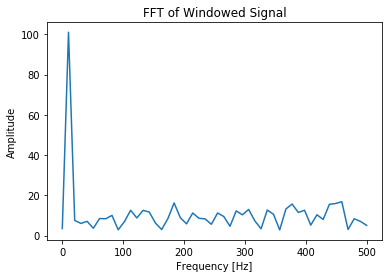

In [33]:
windowed_fft = fft(windowed_y)
plt.title("FFT of Windowed Signal")
plt.ylabel("Amplitude")
plt.xlabel("Frequency [Hz]")
plt.plot(xfreq, (2/total_samples)*abs(fft_signal[:int(N)])) # 2/N normalization

## Designing the FIR filter

Now we design our 4 tap FIR filter. With given parameters: 


Ps: This example is taken from [SciPy Cookbook](https://scipy-cookbook.readthedocs.io/items/FIRFilter.html)

In [34]:
# The Nyquist rate of the signal.
nyq_rate = sampling_freq / 2.0

# The desired width of the transition from pass to stop,
# relative to the Nyquist rate.  We'll design the filter
# with a 5 Hz transition width.
width = 5.0/nyq_rate

# The desired attenuation in the stop band, in dB.
ripple_db = 60.0

# Compute the order and Kaiser parameter for the FIR filter.
N, beta = kaiserord(ripple_db, width)

print(N, beta)

# The cutoff frequency of the filter.
cutoff_hz = 10.0

# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = firwin(N, cutoff_hz/nyq_rate, window=('kaiser', beta))

# Use lfilter to filter x with the FIR filter.
filtered_x = lfilter(taps, 1.0, x)

727 5.65326
